In [1]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'


import sys
sys.path.append('conditional_gan/')

import datetime
import warnings


In [2]:
warnings.filterwarnings('ignore')

In [3]:
import torch.utils.data
import os.path
import random
import torchvision.transforms as transforms
import numpy as np
from numpy import inf
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib.pyplot import figure


In [4]:
test_data_input = dict(np.load('datasets/livneh/testA.npz'))
test_data_ouput = dict(np.load('datasets/livneh/testB.npz'))

In [5]:
starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)

In [6]:
starting_day

datetime.date(2011, 10, 20)

In [7]:
model_path = "conditional_gan/SavedModels/cGan6Channel"

In [8]:
test_data_input.keys()

dict_keys(['variables', 'data', 'metadata'])

In [9]:
test_data_input['data'].shape

(804, 64, 64, 6)

In [10]:
test_data_ouput['data'].shape

(804, 64, 64, 1)

In [11]:
data_A = test_data_input['data']
data_B = test_data_ouput['data']

In [12]:
def take_two_weeks(input_data, start_date):
    return input_data[start_date:start_date + 14, :, :, :]

In [13]:
take_two_weeks(test_data_ouput['data'], 10).shape

(14, 64, 64, 1)

In [14]:
from networks import define_G

In [15]:
model = define_G(6, 1, 16, 'instance', 'resnet', False, [0])
model

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): Reflect

In [16]:
model.load_state_dict(torch.load(model_path)['netG_A_B'])
model.eval()

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): Reflect

In [17]:
torch.histc(torch.from_numpy(test_data_ouput['data'][1,:,:,:]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [18]:
#plt.imshow(model(torch.from_numpy(arr_to_input(data_A[150:151, :, :, :])).cuda()).cpu().detach().numpy()[0,0,:,:])

In [19]:
figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')

<Figure size 80x80 with 0 Axes>

<Figure size 80x80 with 0 Axes>

In [20]:
#normalizing data
def arr_to_input(arr):
    arr = np.nan_to_num(arr)
    if arr.ndim == 3:
        arr = np.expand_dims(arr, axis=2)
    means = np.nanmean(arr, axis=(0,1,2))
    # scale and shift to [-1,1]
    arr = -1 + 2 * (arr - arr.min((1,2))[:, np.newaxis,np.newaxis]) / (arr.max((1,2))[:, np.newaxis,np.newaxis] - arr.min((1,2))[:, np.newaxis,np.newaxis])
    arr[np.isnan(arr)] = -1; arr[arr == inf] = -1; arr[arr == -inf] = -1
    if 64 is not None:
        new_arr = []
        #print "Resizing data to %d" % 64
        for x in arr:
            new_arr.append(resize(x, (64,64)))
        arr = np.stack(new_arr)
    # convert data from b,0,1,c to b,c,0,1
    arr = np.transpose(arr, (0,3,1,2))
    
    return arr.astype('float32')

In [21]:
temp = arr_to_input(data_A[150:151,:,:,:])

In [22]:
temp[0,1].shape

(64, 64)

In [23]:
temp1 = np.concatenate((temp[0,0], temp[0,1], temp[0,2]))

In [24]:
temp2 = np.concatenate((temp[0,3], temp[0,4], temp[0,5]))

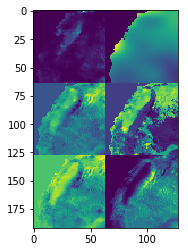

In [25]:
plt.imshow(np.concatenate((temp1, temp2), axis = 1))

In [26]:
temp = arr_to_input(data_B[150:151,:,:,:])

In [27]:
temp.shape

(1, 1, 64, 64)

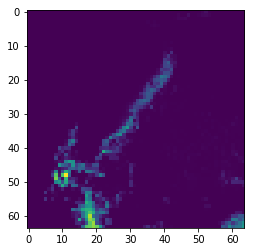

In [28]:
plt.imshow(temp[0,0, :,:])

In [29]:
def hist_kl_div(tenA, tenB, numbins):
    min_elem = min(torch.min(tenA).item(), torch.min(tenB).item())
    max_elem = max(torch.max(tenA).item(), torch.max(tenB).item())
    #print(min_elem, max_elem)
    histA = torch.histc(tenA.cpu(), numbins, min_elem, max_elem)
    histB = torch.histc(tenB.cpu(), numbins, min_elem, max_elem)
    eps = 1e-4
    histA = (histA+eps)*1.0/torch.sum(histA)
    histB = (histB+eps)*1.0/torch.sum(histB)
    return torch.sum(histA * (torch.log(histA) - torch.log(histB)))

In [30]:
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)

In [31]:
def plot_histograms(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    
    
    
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im, 1000, None, ec='blue',  histtype='step', label='Real Data')
    ax.hist(fake_im, 1000, None, ec='green',  histtype='step', label='Generated Data')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)
            
#     fig, ax = plt.subplots(nrows=14, ncols=1, figsize=(15, 45))
#     divergences = []
#     for row in ax:
#         colors = ['blue', 'lime']
#         real_im = np.ravel(real_B[curr_day, :,:,:].detach().numpy())
#         fake_im = np.ravel(fake_B[curr_day, :,:,:].detach().numpy())
#         common_params = dict(bins=100, range=(min(np.min(real_im), np.min(fake_im)), max(np.max(real_im), np.max(fake_im))), normed=True, color = colors, label = ['real', 'fake'])
#         #col.title = 'Histograms of Real vs Fake data on day ' + str(start_date + curr_day)
#         row.hist((real_im, fake_im), **common_params)
#         row.legend(prop={'size': 10})

        
#         divergences.append(hist_kl_div(real_B[curr_day, :,:,:].detach(), fake_B[curr_day, :,:,:].detach(), 100))
#         curr_day +=1
    #return divergences

In [32]:
mask = np.load("OceanMask.npy")
mask = resize(mask.astype(np.float), (64,64))
mask[mask == 1] = np.nan
mask = mask + 1

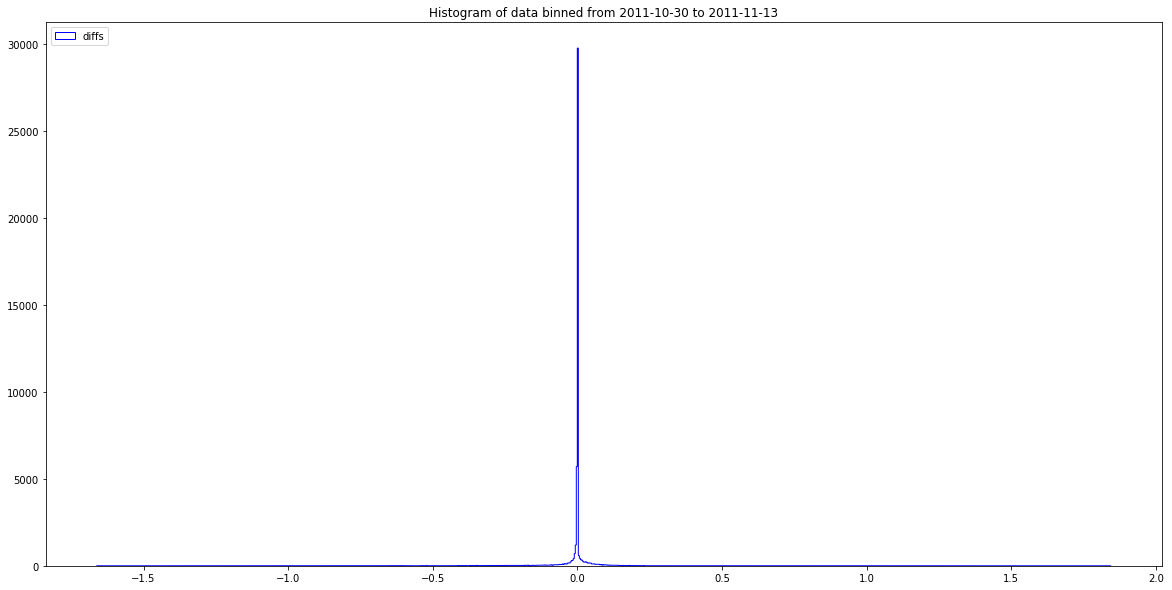

In [33]:
plot_hist_diffs(10, data_A, data_B, mask)

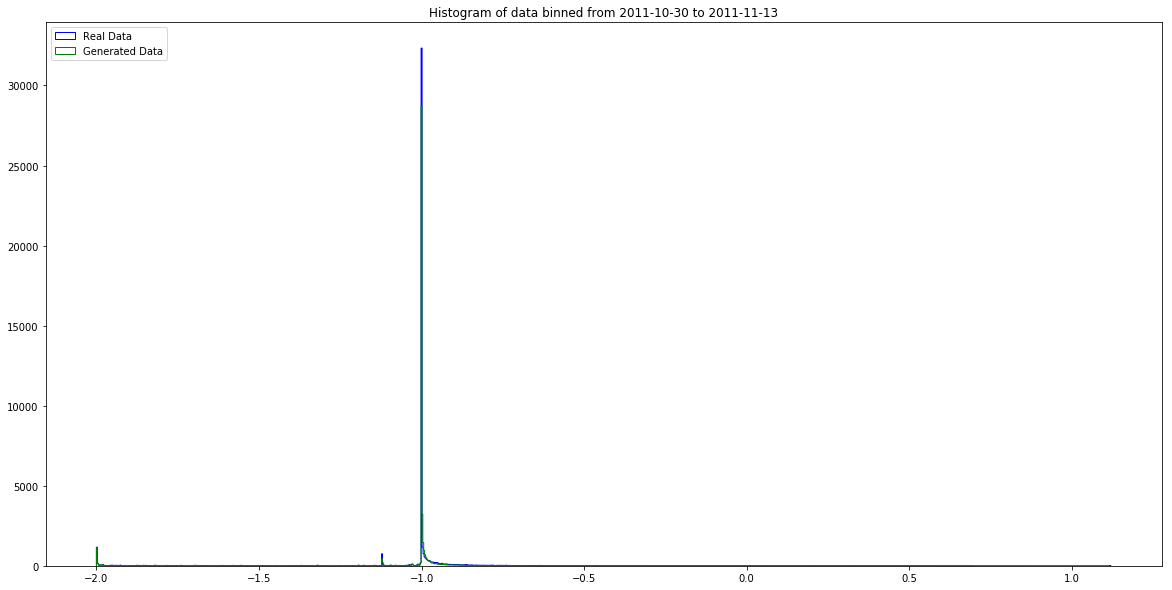

In [34]:
plot_histograms(10, data_A, data_B, mask)

In [35]:
def pearson_coeff(start_date, inputA, inputB):
    fakeB = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).detach().cpu().numpy()
    realB = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date))).numpy()
    
    xbar = np.mean(fakeB, axis=0)
    ybar = np.mean(realB, axis=0)
    xSTDev = np.std(fakeB, axis=0)
    ySTDev = np.std(realB, axis=0)
    r = np.mean(((fakeB - xbar)/(xSTDev)) * ((realB - ybar)/(ySTDev)), axis = 0)
    return r
    

In [36]:
def kge(start_date, inputA, inputB):
    fakeB = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).detach().cpu().numpy()
    realB = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date))).numpy()
    
    xbar = np.mean(fakeB, axis=0)
    ybar = np.mean(realB, axis=0)
    xSTDev = np.std(fakeB, axis=0)
    ySTDev = np.std(realB, axis=0)
    r = np.mean(((fakeB - xbar)/(xSTDev)) * ((realB - ybar)/(ySTDev)), axis = 0)
    
    KGE = 1 - np.sqrt((r - 1)**2 + (xbar/ybar - 1)**2 + (xSTDev/ySTDev - 1)**2)
    return KGE

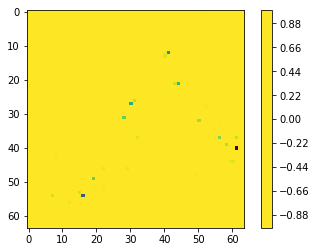

In [37]:
ax = plt.imshow(np.nan_to_num(kge(400, data_A, data_B))[0,:,:])
plt.colorbar(ax, boundaries=np.linspace(-1,1,101))


In [38]:
#Making better looking histograms

In [39]:
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)

In [40]:
def numpy_histograms(start_date, inputA, inputB, zero_mask, num_bins, to_plot = True):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    
    
    mask = np.ravel(np.tile(zero_mask, (real_B.shape[0], 1, 1, 1)))
    
    real_im = np.ravel(real_B.detach().numpy())*(mask/mask)
    fake_im = np.ravel(fake_B.detach().numpy())*(mask/mask)

    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    print(np.mean(real_im))

    
    
    #
    
    #got everything setup, now make bins and counts
    
    real_hist_data = np.histogram(real_im, bins=num_bins)
    fake_hist_data = np.histogram(fake_im, bins=num_bins)
    
    if to_plot:
        fix, ax = plt.subplots(figsize=(10, 10))
        ax.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
        ax.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
        ax.legend(loc='upper right')
        title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
        ax.set_title(title)
        ax.set_yscale('log')
        ax.set_xlabel('Normalized Pixel Values')
        ax.set_ylabel('Log Counts')


    
    return real_hist_data, fake_hist_data


-0.9716047024615909


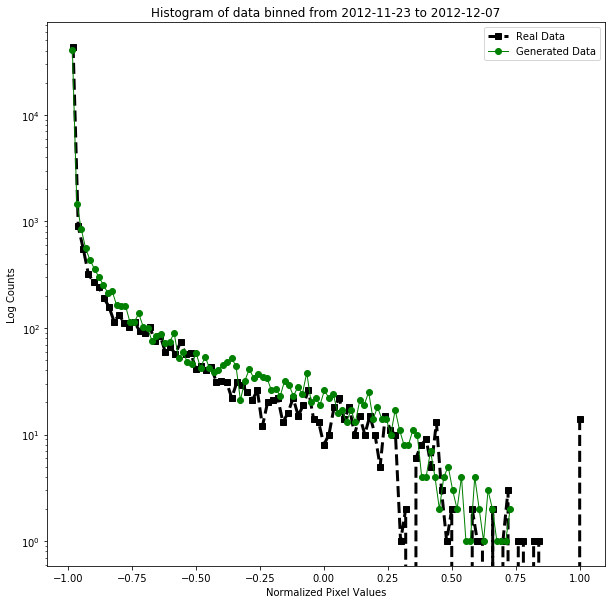

In [41]:
real_hist, fake_hist = numpy_histograms(400, data_A, data_B, mask, 100)

-0.999282296780529


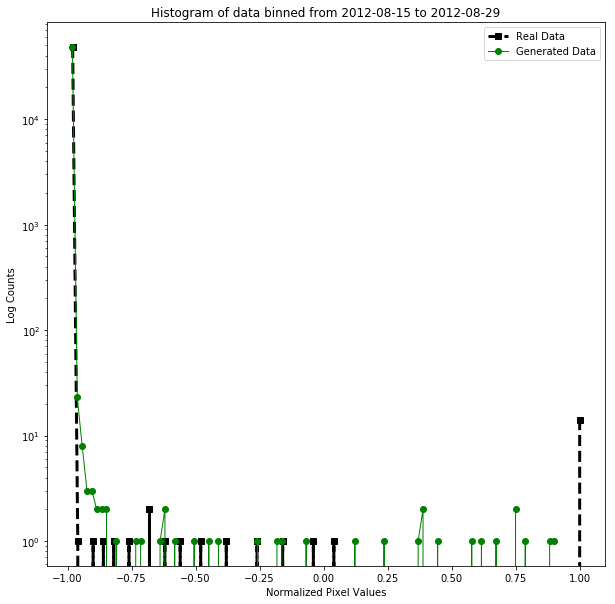

In [42]:
real_hist, fake_hist = numpy_histograms(300, data_A, data_B, mask, 100)

-0.9657506888526106


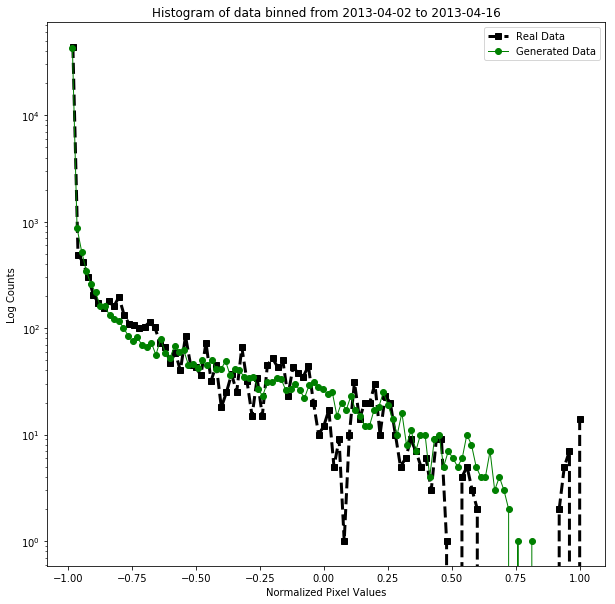

In [43]:
real_hist, fake_hist = numpy_histograms(530, data_A, data_B, mask, 100)

In [44]:
def take_n_samples_random(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]

In [45]:
# fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
# real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))

In [46]:
def nov_aug_apr_hist(inputA, inputB, mask):
    starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
    

    
    
    f = plt.figure(figsize=(30,40))
    f.patch.set_facecolor('white')

    gs = gridspec.GridSpec(6, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    
    ax4 = plt.subplot(gs[1, 0])
    ax5 = plt.subplot(gs[1, 1])
    ax6 = plt.subplot(gs[1, 2])
    
    ax7 = plt.subplot(gs[2:4, 0:3])
    ax8 = plt.subplot(gs[4, 0:3])
    
    ax9 = plt.subplot(gs[5, 0:3])
    
    #ax10 = plt.subplot(gs[5, 0:3])
    
#     ax8 = plt.subplot(gs[2, 2])
    
    
    start_date = 300
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax1.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax1.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax1.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax1.set_title(title)
    ax1.set_yscale('log')
    ax1.set_xlabel('Normalized Pixel Values')
    ax1.set_ylabel('Log Counts')
    
    temp = ax4.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap='gray')
    plt.colorbar(temp, ax = ax4, boundaries=np.linspace(-1,1,101))
    ax4.set_title("Correlation Coeffs over " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))

    
    start_date = 400
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax2.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax2.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax2.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax2.set_title(title)
    ax2.set_yscale('log')
    ax2.set_xlabel('Normalized Pixel Values')
    ax2.set_ylabel('Log Counts')
    
    temp = ax5.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax5, boundaries=np.linspace(-1,1,101))
    ax5.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    start_date = 530
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax3.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax3.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax3.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax3.set_title(title)
    ax3.set_yscale('log')
    ax3.set_xlabel('Normalized Pixel Values')
    ax3.set_ylabel('Log Counts')
    
    
    temp = ax6.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax6, boundaries=np.linspace(-1,1,101))
    ax6.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    
#     ax8.spy(mask)
#     ax8.set_title("Mask Used for ignoring irrelevant data like ocean")
    num_samples = 10
    
    sampled_input, sampled_output_real = take_n_samples_random(inputA, inputB, num_samples)
    
    sampled_input = torch.from_numpy(arr_to_input(sampled_input)[:,:,:,:])
    
    sampled_output_fake = model(sampled_input.cuda()).cpu()
    sampled_output_real = torch.from_numpy(arr_to_input(sampled_output_real))
    #print(sampled_input.shape, sampled_output_fake.shape, sampled_output_real.shape)
    sampled_outputs = torch.cat((sampled_output_fake, sampled_output_real, torch.abs(sampled_output_fake - sampled_output_real)), 1)

    
    
    img1 = np.hstack([image for image in sampled_input.detach().numpy().reshape(num_samples, 64*6, 64)])
    img2 = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 64*3, 64)])
    
    print(img1.shape, img2.shape)
    img3 = np.vstack([img1, img2])
    dx, dy = 64,64

    # Custom (rgb) grid color
    grid_color = 1

    # Modify the image to include the grid
    img3[:,::dy] = grid_color
    img3[::dx,:] = grid_color
    
    temp = ax7.imshow(img3)
    plt.colorbar(temp, ax = ax7)
    ax7.set_ylabel("ERROR || FAKE SWE || REAL SWE || HEIGHT || NET RAD || WIND || TEMP MIN || TEMP MAX || PRECIP")

    
    

    

#     # Modify the image to include the grid
#     img[:,::dy] = grid_color
#     img[::dx,:] = grid_color

    
    
#     temp = ax8.imshow(img)
#     plt.colorbar(temp, ax = ax8)
#     ax8.set_ylabel("OUTPUTS")
    
    
    
    
    
    
    sampled_output_fake_down = torch.from_numpy(np.array([downscale_local_mean(i[0,:,:], (2,2)) for i in sampled_output_fake.detach().numpy()]))
    sampled_output_real_down = torch.from_numpy(np.array([downscale_local_mean(i[0,:,:], (2,2)) for i in sampled_output_real.detach().numpy()]))
    
    diff = torch.abs(sampled_output_fake_down - sampled_output_real_down)
    
    sampled_outputs = torch.cat((sampled_output_fake_down, sampled_output_real_down), 1)
    img = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 32*2, 32)])
    
    img[:,::32] = grid_color
    img[::32,:] = grid_color

    
    
    temp = ax9.imshow(img)
    plt.colorbar(temp, ax = ax9)
    ax9.set_ylabel("AVGPOOL: REAL, GENERATED")
    
    img = np.hstack([image for image in diff.numpy().reshape(num_samples, 32, 32)])
    
    img[:,::32] = grid_color
    img[::32,:] = grid_color

    
    
#     temp = ax10.matshow(img, cmap='gray')
#     plt.colorbar(temp, ax = ax10)
#     ax10.set_ylabel("AVGPOOL: ERRORS")
    
    


    
    


-0.999282296780529
-0.9716047024615909
-0.9657506888526106
(384, 640) (192, 640)


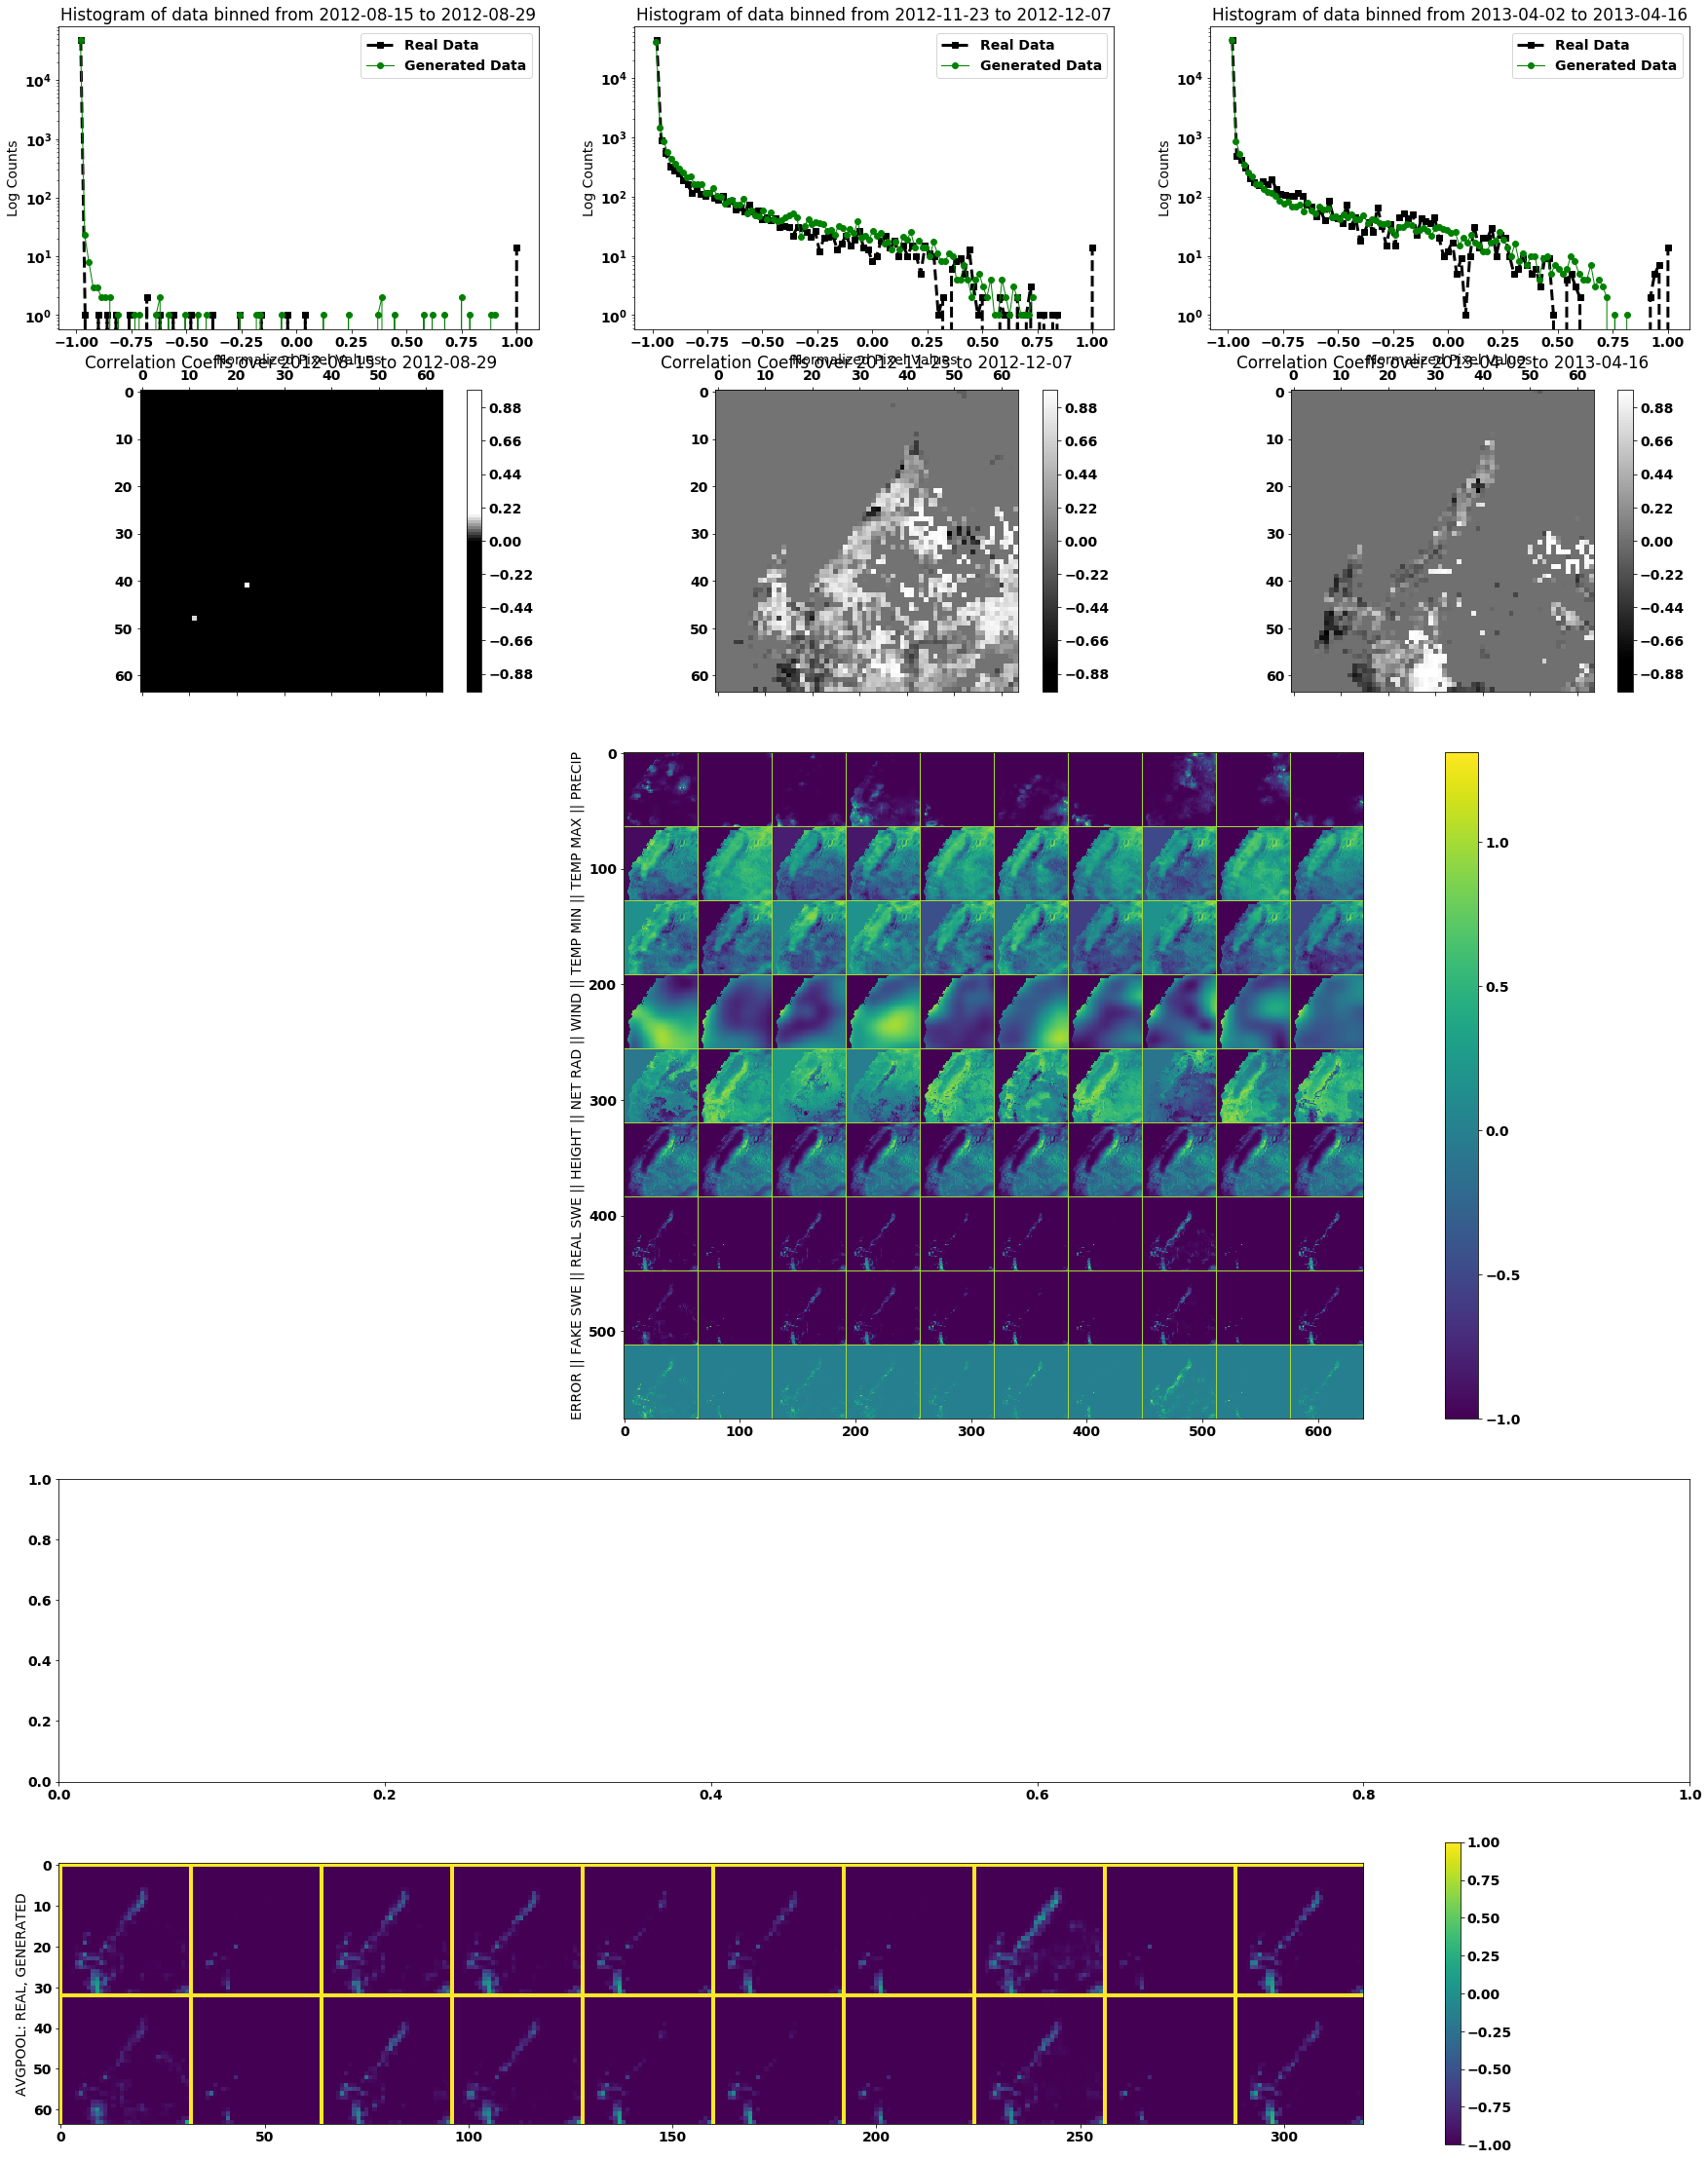

In [47]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)


nov_aug_apr_hist(data_A, data_B, mask)

In [48]:
def nov_aug_apr_hist(inputA, inputB, mask):
    starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
    

    
    
    f = plt.figure(figsize=(30,40))
    f.patch.set_facecolor('white')

    gs = gridspec.GridSpec(6, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    
    ax4 = plt.subplot(gs[1, 0])
    ax5 = plt.subplot(gs[1, 1])
    ax6 = plt.subplot(gs[1, 2])
    
    ax7 = plt.subplot(gs[2, 0:3])
    ax8 = plt.subplot(gs[3, 0:3])
    
    ax9 = plt.subplot(gs[4, 0:3])
    
    ax10 = plt.subplot(gs[5, 0:3])
    
#     ax8 = plt.subplot(gs[2, 2])
    
    
    start_date = 300
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax1.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax1.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax1.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax1.set_title(title)
    ax1.set_yscale('log')
    ax1.set_xlabel('Normalized Pixel Values')
    ax1.set_ylabel('Log Counts')
    
    temp = ax4.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap='gray')
    plt.colorbar(temp, ax = ax4, boundaries=np.linspace(-1,1,101))
    ax4.set_title("Correlation Coeffs over " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))

    
    start_date = 400
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax2.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax2.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax2.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax2.set_title(title)
    ax2.set_yscale('log')
    ax2.set_xlabel('Normalized Pixel Values')
    ax2.set_ylabel('Log Counts')
    
    temp = ax5.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax5, boundaries=np.linspace(-1,1,101))
    ax5.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    start_date = 530
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax3.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax3.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax3.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax3.set_title(title)
    ax3.set_yscale('log')
    ax3.set_xlabel('Normalized Pixel Values')
    ax3.set_ylabel('Log Counts')
    
    
    temp = ax6.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax6, boundaries=np.linspace(-1,1,101))
    ax6.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    
#     ax8.spy(mask)
#     ax8.set_title("Mask Used for ignoring irrelevant data like ocean")
    num_samples = 10
    
    sampled_input, sampled_output_real = take_n_samples_random(inputA, inputB, num_samples)
    
    sampled_input = torch.from_numpy(arr_to_input(sampled_input)[:,:,:,:])
    
    sampled_output_fake = model(sampled_input.cuda()).cpu()
    sampled_output_real = torch.from_numpy(arr_to_input(sampled_output_real))
    #print(sampled_input.shape, sampled_output_fake.shape, sampled_output_real.shape)
    
    
    img = np.hstack([image for image in sampled_input.detach().numpy().reshape(num_samples, 64*3, 64)])
    dx, dy = 64,64

    # Custom (rgb) grid color
    grid_color = 1

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color
    
    temp = ax7.imshow(img)
    plt.colorbar(temp, ax = ax7)
    ax7.set_ylabel("INPUT CHANNELS: TMIN, TMAX, PRECIPITATION")

    
    
    sampled_outputs = torch.cat((sampled_output_fake, sampled_output_real, torch.abs(sampled_output_fake - sampled_output_real)), 1)
    img = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 64*3, 64)])

    

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color

    
    
    temp = ax8.imshow(img)
    plt.colorbar(temp, ax = ax8)
    ax8.set_ylabel("OUTPUTS: ERROR, REAL, GENERATED")
    
    
    
    
    
    
    sampled_output_fake_down = torch.from_numpy(np.array([downscale_local_mean(i[0,:,:], (2,2)) for i in sampled_output_fake.detach().numpy()]))
    sampled_output_real_down = torch.from_numpy(np.array([downscale_local_mean(i[0,:,:], (2,2)) for i in sampled_output_real.detach().numpy()]))
    
    diff = torch.abs(sampled_output_fake_down - sampled_output_real_down)
    
    sampled_outputs = torch.cat((sampled_output_fake_down, sampled_output_real_down), 1)
    img = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 32*2, 32)])
    
    img[:,::32] = grid_color
    img[::32,:] = grid_color

    
    
    temp = ax9.imshow(img)
    plt.colorbar(temp, ax = ax9)
    ax9.set_ylabel("AVGPOOL: REAL, GENERATED")
    
    img = np.hstack([image for image in diff.numpy().reshape(num_samples, 32, 32)])
    
    img[:,::32] = grid_color
    img[::32,:] = grid_color

    
    
    temp = ax10.matshow(img, cmap='gray')
    plt.colorbar(temp, ax = ax10)
    ax10.set_ylabel("AVGPOOL: ERRORS")
    
    

In [49]:
fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(data_A, 100))[:,:,:,:]).cuda())
real_B = torch.from_numpy(arr_to_input(take_two_weeks(data_B, 100)))

In [115]:
4018 - 804

3214

In [52]:
def take_n_samples_random(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]

In [161]:

model_output.shape

(804, 1, 64, 64)

In [53]:
model_output = model(torch.from_numpy(arr_to_input(data_A)).cuda()).cpu().detach().numpy()

In [54]:
np.sqrt(np.mean((arr_to_input(data_B) - model_output)**2))

0.065195315

In [55]:
np.mean(np.abs((arr_to_input(data_B) - model_output)))

0.013278133

In [56]:
100*np.mean(np.abs((arr_to_input(data_B) - model_output)/arr_to_input(data_B)))

9.542999416589737

In [57]:
import time


In [58]:
# i = 10
# sampled_in, sampled_out = take_n_samples_random(data_A, data_B, 2**i)
# start = time.clock()
# model_output = model(torch.from_numpy(arr_to_input(sampled_in)).cuda()).cpu().detach().numpy()
# print ("The model takes the following time for " + str(2**i) + " samples")
# print (time.clock() - start)

In [89]:
snotel_data = dict(np.load("snotel_values_and_index.npz"))

In [109]:
snotel_names = snotel_data['arr_0']
snotel_names

array(['Ward Creek #3', 'Big Meadow', 'Lobdell Lake',
       'Virginia Lakes Ridge', 'Independence Camp', 'Ebbetts Pass',
       'Burnside Lake', 'Css Lab', 'Independence Lake', 'Sonora Pass',
       'Leavitt Lake', 'Independence Creek', 'Horse Meadow',
       'Hagans Meadow', 'Little Valley', 'Marlette Lake', 'Monitor Pass',
       'Squaw Valley G.C.', 'Leavitt Meadows', 'Tahoe City Cross',
       'Fallen Leaf', 'Truckee #2', 'Rubicon #2', 'Heavenly Valley',
       'Summit Meadow', 'Carson Pass', 'Forestdale Creek',
       'Mt Rose Ski Area', 'Blue Lakes', 'Spratt Creek', 'Echo Peak',
       'Poison Flat'], dtype='<U20')

In [110]:
snotel_values = snotel_data['arr_1'][:,1]
snotel_values

array([array([485, 490, 490, ...,  81,  81,  81]),
       array([338, 338, 338, ...,  43,  43,  43]),
       array([328, 328, 328, ...,  20,  20,  20]),
       array([277, 282, 284, ...,  25,  25,  25]),
       array([218, 218, 218, ...,  20,  20,  13]),
       array([508, 516, 523, ...,  94,  94,  94]),
       array([925, 925, 925, ...,  84,  84,  84]),
       array([577, 582, 587, ...,  66,  66,  66]),
       array([716, 721, 724, ...,  79,  79,  79]),
       array([384, 394, 404, ...,  56,  56,  56]),
       array([945, 945, 947, ..., 135, 135, 135]),
       array([206, 206, 203, ...,  13,  13,  13]),
       array([480, 480, 478, ...,  61,  61,  61]),
       array([282, 284, 284, ...,  41,  41,  41]),
       array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  10,  18,  25,  23,  15,   8,   5,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [111]:
snotel_indices = snotel_data['arr_1'][:,0]
snotel_indices

array([array([164, 153]), array([175, 162]), array([142, 180]),
       array([130, 185]), array([174, 151]), array([146, 166]),
       array([151, 163]), array([170, 148]), array([174, 150]),
       array([138, 173]), array([137, 172]), array([176, 151]),
       array([155, 164]), array([155, 162]), array([168, 164]),
       array([165, 163]), array([149, 173]), array([166, 151]),
       array([138, 174]), array([165, 155]), array([158, 158]),
       array([170, 154]), array([160, 156]), array([158, 163]),
       array([141, 175]), array([150, 160]), array([150, 161]),
       array([170, 163]), array([147, 162]), array([149, 166]),
       array([155, 157]), array([144, 172])], dtype=object)

In [134]:
snotel_values[2].shape

(4018,)

In [152]:
def normalize_by_peak(swe):
    return swe / np.max(swe)

In [170]:
def zero_one_norm_peak(swe):
    temp = 1 + swe
    return temp / np.max(temp)

In [303]:
def plot_station_vs_sim(index, model_output):
    plt.rcParams["figure.figsize"] = (30,10)
    print(snotel_names[index])
    if snotel_values[index].shape[0] != 4018:
        return "improper data alignment"
    else:
        plt.plot(normalize_by_peak(snotel_values[index][3214:]), 'g')
        plt.plot(normalize_by_peak(data_B[:, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321), 0]), 'b')
        plt.plot(zero_one_norm_peak(model_output[:, 0, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321)]), 'r:')

Independence Creek


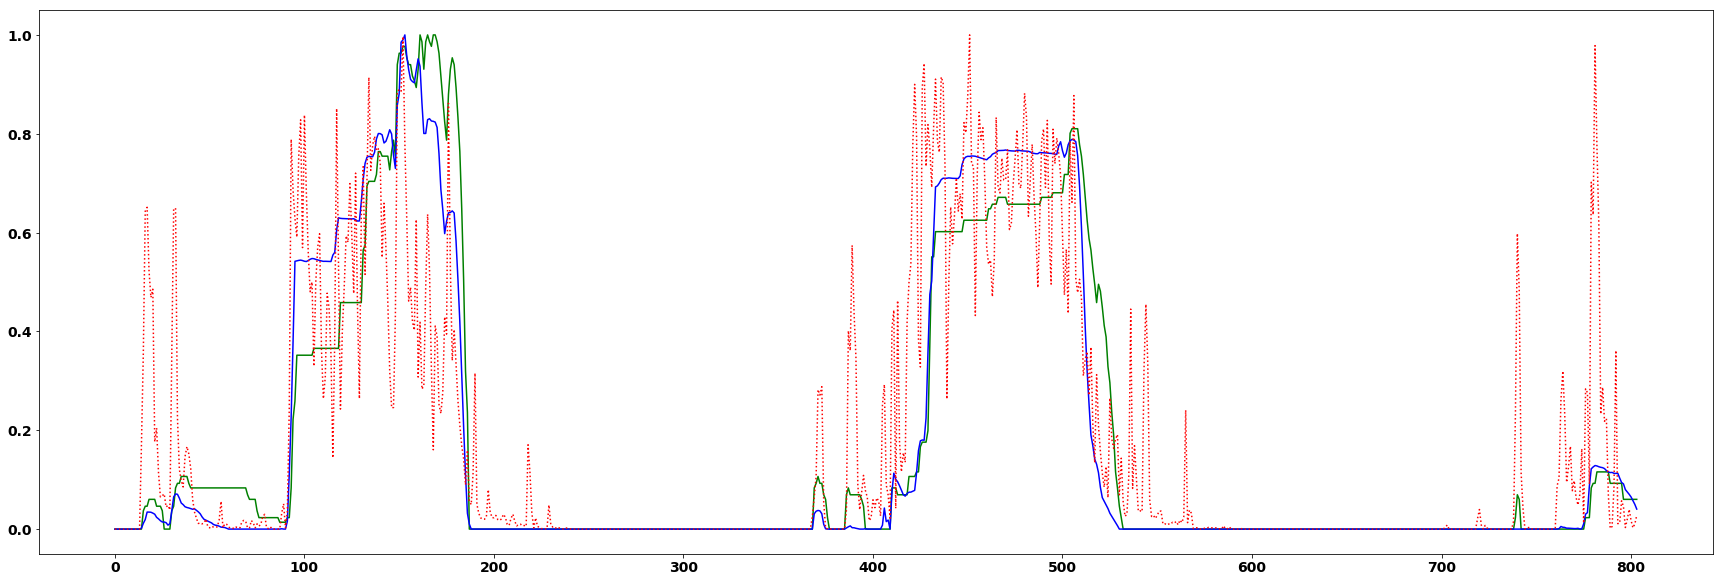

In [304]:
plot_station_vs_sim(11, model_output)

In [292]:
valid_snotel = []
for index in range(0, 32):
    if snotel_values[index].shape[0] == 4018:
        print(snotel_names[index], index)
        valid_snotel.append(index)

Big Meadow 1
Lobdell Lake 2
Virginia Lakes Ridge 3
Independence Camp 4
Ebbetts Pass 5
Css Lab 7
Independence Lake 8
Sonora Pass 9
Leavitt Lake 10
Independence Creek 11
Hagans Meadow 13
Marlette Lake 15
Monitor Pass 16
Squaw Valley G.C. 17
Leavitt Meadows 18
Tahoe City Cross 19
Fallen Leaf 20
Truckee #2 21
Rubicon #2 22
Heavenly Valley 23
Mt Rose Ski Area 27
Blue Lakes 28
Spratt Creek 29
Echo Peak 30
Poison Flat 31


Big Meadow 1
Lobdell Lake 2
Virginia Lakes Ridge 3
Independence Camp 4
Ebbetts Pass 5
Css Lab 7
Independence Lake 8
Sonora Pass 9
Leavitt Lake 10
Independence Creek 11
Hagans Meadow 13
Marlette Lake 15
Monitor Pass 16
Squaw Valley G.C. 17
Leavitt Meadows 18
Tahoe City Cross 19
Fallen Leaf 20
Truckee #2 21
Rubicon #2 22
Heavenly Valley 23
Mt Rose Ski Area 27
Blue Lakes 28
Spratt Creek 29
Echo Peak 30
Poison Flat 31


In [264]:
valid_snotel

[1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 27,
 28,
 29,
 30,
 31]

In [266]:
objects = snotel_names[valid_snotel]
y_pos = np.arange(len(objects))


array(['Big Meadow', 'Lobdell Lake', 'Virginia Lakes Ridge',
       'Independence Camp', 'Ebbetts Pass', 'Css Lab',
       'Independence Lake', 'Sonora Pass', 'Leavitt Lake',
       'Independence Creek', 'Hagans Meadow', 'Marlette Lake',
       'Monitor Pass', 'Squaw Valley G.C.', 'Leavitt Meadows',
       'Tahoe City Cross', 'Fallen Leaf', 'Truckee #2', 'Rubicon #2',
       'Heavenly Valley', 'Mt Rose Ski Area', 'Blue Lakes',
       'Spratt Creek', 'Echo Peak', 'Poison Flat'], dtype='<U20')

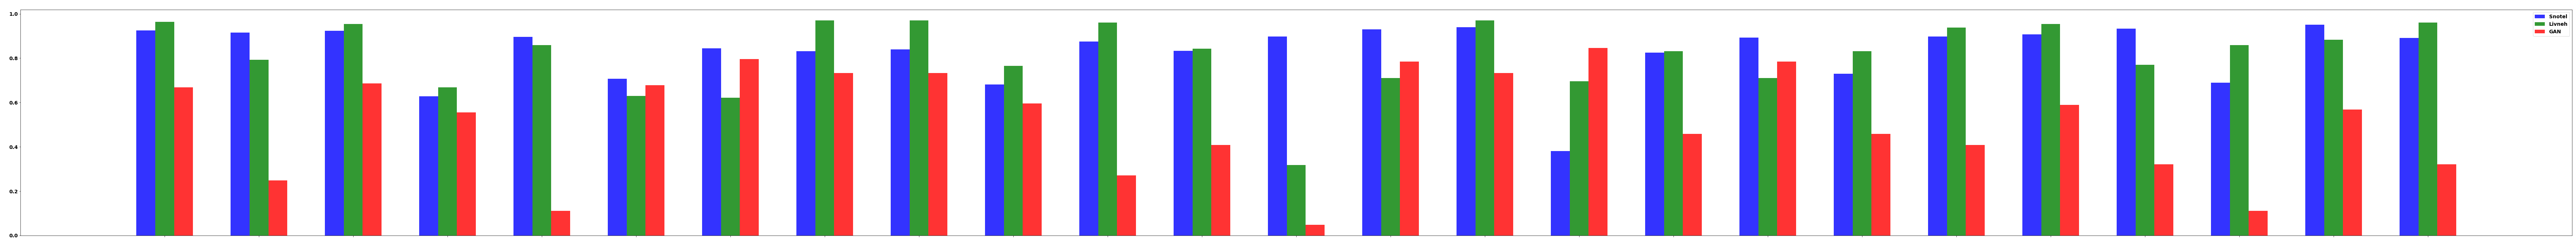

In [319]:
start_day = 500
end_day = start_day + 1
plt.rcParams["figure.figsize"] = (100,10)
plt.rcParams['axes.facecolor'] = 'white'


n_groups = len(valid_snotel)
vals_snotel = [np.mean(normalize_by_peak(snotel_values[index][3214:])[start_day:end_day]) for index in valid_snotel]
vals_livneh = [np.mean(normalize_by_peak(data_B[:, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321), 0])[start_day:end_day]) for index in valid_snotel]
vals_gan = [np.mean(zero_one_norm_peak(model_output[:, 0, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321)])[start_day:end_day]) for index in valid_snotel]
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, vals_snotel, bar_width,alpha=opacity,color='b',label='Snotel')
rects2 = plt.bar(index + bar_width, vals_livneh, bar_width,alpha=opacity,color='g',label='Livneh')
rects3 = plt.bar(index + 2*bar_width, vals_gan, bar_width,alpha=opacity,color='r',label='GAN')

plt.xlabel('Stations', color = 'white')
plt.ylabel('Normalized SWE', color = 'white')
plt.title('snotel v livneh v gan', color = 'white')
plt.xticks(index + bar_width, snotel_names[valid_snotel], color = 'white')
plt.legend()

plt.tight_layout()

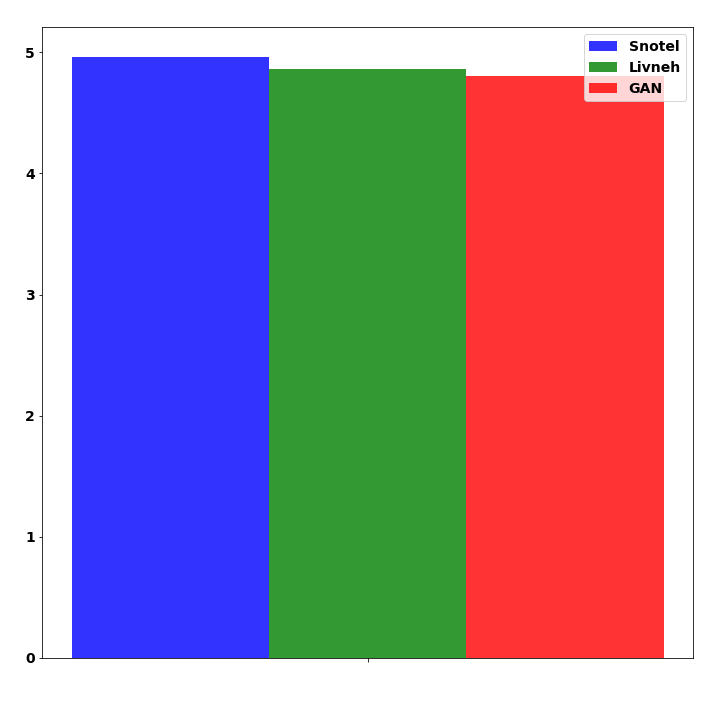

In [318]:
start_day = 0
end_day = 804
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.facecolor'] = 'white'


n_groups = 1
vals_snotel = sum([np.mean(normalize_by_peak(snotel_values[index][3214:])[start_day:end_day]) for index in valid_snotel])
vals_livneh = sum([np.mean(normalize_by_peak(data_B[:, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321), 0])[start_day:end_day]) for index in valid_snotel])
vals_gan = sum([np.mean(zero_one_norm_peak(model_output[:, 0, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321)])[start_day:end_day]) for index in valid_snotel])
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, vals_snotel, bar_width,alpha=opacity,color='b',label='Snotel')
rects2 = plt.bar(index + bar_width, vals_livneh, bar_width,alpha=opacity,color='g',label='Livneh')
rects3 = plt.bar(index + 2*bar_width, vals_gan, bar_width,alpha=opacity,color='r',label='GAN')

plt.xlabel('Stations', color = 'white')
plt.ylabel('Normalized SWE', color = 'white')
plt.title('snotel v livneh v gan', color = 'white')
plt.xticks(index + bar_width, snotel_names[valid_snotel], color = 'white')
plt.legend()

plt.tight_layout()

In [313]:
#for day    
    